# 4. Batch effect correction

This module provides statistical tools to handle **replicate measurements** and quantify the contribution of **experimental noise** in genotype–phenotype landscapes.

It includes routines for:
- **Batch-effect correction** across replicate experiments or measurement days.  
- **Estimation of replicate residuals and covariance** to characterize measurement variability.  
- **Projection of noise into the Walsh–Hadamard (WH) basis** to evaluate how experimental uncertainty affects each interaction mode.  
- **Correction of the variance spectrum** to remove the expected contribution of noise (“noise floor”) and isolate the true biological signal.

---

## 4.1. Importing the required packages

In this tutorial, we will use:

- **`numpy`** — for numerical operations and array handling.  
- **`pandas`** — to manage and visualize tabular data.  
- **`matplotlib`** — for simple visualizations and plots.  
- **`epistasia`** — the main package used for representing and analyzing binary landscapes.

We will also define a small helper `header` function for formatted section headers, and adjust the Python path so the interpreter can find the `epistasia` package locally.

In [1]:
###########################
#         IMPORTS         #
###########################

import os
import numpy as np
import pandas as pd
import itertools

from math import comb

from matplotlib import pyplot as plt
plt.style.use('./style.mplstyle') #include plotsyle

import sys

###########################
#         HELPERS         #
###########################

# Pretty printing helper
def header(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

#############################################
#     LOAD BINARY LANDSCAPES DEPENDENCE     #
#############################################

#INCLUDE YOUR PATH HERE
base_path = os.path.expanduser("~/FunEcoLab_IBFG Dropbox/")
sys.path.insert(1, base_path)

#READ DATA FRAME WITH LANDSCAPE FORMAT
import epistasia as ep

We define a demo landscape from an arbitrary ecological function 

In [2]:
F_bar_clean = np.array([1.00, 1.10, 1.20, 1.30, 1.40, 1.50, 1.60, 1.70])

df = pd.DataFrame({
    "s0": [0, 0, 0, 1, 1, 1, 0, 1],
    "s1": [0, 0, 1, 0, 1, 1, 1, 0],
    "s2": [0, 1, 0, 0, 0, 1, 1, 1],
    # All replicates identical: no noise between replicates at this stage.
    "rep1": F_bar_clean,
    "rep2": F_bar_clean,
    "rep3": F_bar_clean,
})

# --- Build a Landscape from the DataFrame ---
L_clean = ep.Landscape.from_dataframe(df)  # N: total number of species -> inferred automatically
                                  # R: total number of replics -> inferred automatically

# Underlying map in log-space (for generative model)
f_bar_log = np.log(F_bar_clean)  # shape (X,)

## 4.2. Batch effect cleaning

Experimental measurements of the landscape $F$ are often affected by systematic differences between batches or replicates. Each batch $r \in \{1, \dots, R\}$ provides a full measurement of the $2^N$ configurations, which we model as

\begin{equation}
\tilde{F}_r(\mathbf{x}) = \bar{F}(\mathbf{x}) + a_r + b_r\,\pi_r(\mathbf{x}).
\end{equation}

Here:
- $\bar{F}(\mathbf{x})$ is the true biological signal shared by all replicates.  
- $a_r$ and $b_r$ are additive and multiplicative *batch effects* that shift and rescale all measurements in batch \(r\).  
- $\pi_r(\mathbf{x})$ represents random experimental noise with zero mean and finite variance.

These parameters correct for non-biological distortions—such as differences in temperature, humidity, or instrument calibration—so that replicate data become comparable. This effect can be corrected using `correct_batch_effect` from `epistasia` package. 

----------------------------------------------

We start from a clean demo landscape `L` (replicates are comparable), and we inject **known** additive and multiplicative batch effects $(a_r, b_r)$ so we can later test recovery.


True batch-effect parameters (log link generative):
a_true_log: [-0.321  0.013  0.308]
b_true: [1.019 0.949 1.034]
Effective tau_a (log-space): 0.257   Effective tau_b: 0.037

Batchy Landscape with injected batch effects and biological noise:
Values shape: (8, 3)


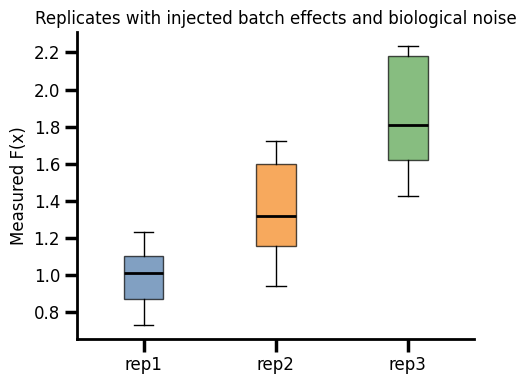

In [3]:
rng = np.random.default_rng(1234)

R = L_clean.R

# True dispersion scales for additive and multipliclicative batch effects (log-space)
tau_a_true = 0.2   # std of a_r in log-space
tau_b_true = 0.12  # std of log b_r

# Additive batch effects in log-space: a_raw_log ~ Normal(0, tau_a),
# then enforce sum(a_log) = 0
a_raw_true_log = rng.normal(0.0, tau_a_true, size=R - 1)
a_true_log = np.empty(R)
a_true_log[: R - 1] = a_raw_true_log
a_true_log[R - 1] = -np.sum(a_raw_true_log)  # identifiability: sum_r a_r_log = 0

# Multiplicative noise scales b_r > 0:
# log_b_raw ~ Normal(0, tau_b), then shift to enforce geommean(b) = 1
log_b_raw_true = rng.normal(0.0, tau_b_true, size=R)
gm_log_b_true = log_b_raw_true.mean()
b_true = np.exp(log_b_raw_true - gm_log_b_true)  # identifiability: geommean(b) = 1

print("\nTrue batch-effect parameters (log link generative):")
print("a_true_log:", np.round(a_true_log, 3))
print("b_true:", np.round(b_true, 3))

# Effective standard deviations (close to tau_a_true and tau_b_true)
tau_a_true_eff = np.std(a_true_log)
tau_b_true_eff = np.std(np.log(b_true))
print("Effective tau_a (log-space):", round(tau_a_true_eff, 3),
      "  Effective tau_b:", round(tau_b_true_eff, 3))

# =====================================================
# 3) Inject biological noise in log-space and batch effects
# =====================================================

X = F_bar_clean.shape[0]

# Biological noise in log-space: pi_log_r(x) = sigma_log * eps_{x,r}
sigma_log_true = 0.05   # std of noise in log(F)
eps = rng.normal(0.0, 1.0, size=(X, R))   # eps_{x,r} ~ N(0,1)
pi_log = sigma_log_true * eps             # shape (X, R)

# Generative model in log-space:
#   Y_r(x) = f_bar_log(x) + a_r_log + b_r * pi_log(x)
Y_noisy = f_bar_log[:, None] + a_true_log[None, :] + b_true[None, :] * pi_log

# Transform back to the original (positive) scale:
#   F'_r(x) = exp(Y_r(x))
V_noisy = np.exp(Y_noisy)  # shape (X, R)

# =====================================================
# 4) Build a "batchy" Landscape with injected batch effects and biological noise
# =====================================================

L_batchy = type(L_clean)(
    L_clean.states,
    V_noisy,
    L_clean.N,
    L_clean.R,
    getattr(L_clean, "order", None),
)

print("\nBatchy Landscape with injected batch effects and biological noise:")
print("Values shape:", L_batchy.values.shape)

# =====================================================
# 5) Display box plots to illustrate batch effects
# =====================================================

colors = ["#4C78A8", "#F58518", "#54A24B"]  # colors per replicate

vals = L_batchy.values  # shape (X, R)

plt.figure(figsize=(5, 4))
box = plt.boxplot(
    [vals[:, r] for r in range(L_batchy.R)],
    tick_labels=[f"rep{r+1}" for r in range(L_batchy.R)],
    patch_artist=True,
)

# Apply custom colors
for patch, color in zip(box["boxes"], colors):
    patch.set(facecolor=color, alpha=0.7)

# Style medians
for median in box["medians"]:
    median.set(color="black", linewidth=2)

plt.ylabel("Measured F(x)")
plt.title("Replicates with injected batch effects and biological noise")
plt.tight_layout()
plt.show()


We correct this effect by using the dependence `correct_batch_effect` from `epistasia` package. This function takes a landscape object and directly reescales by $a_r$ and $b_r$

In [4]:
# --- 5) Apply batch-effect correction and recover parameters ---
# If you imported the package as 'ep', the module lives in ep.sn
L_corr, post = ep.correct_batch_effect(
    L_batchy,
    return_posteriors=True,
    seed=12345,
    chains=2,
    iter_warmup=1000,
    iter_sampling=1000,
    link="log",
    adjust_zero_state=True,
)

# Posterior means as point estimates (a_r are in log-space)
a_hat_log = post["a"].mean(axis=0)  # (R,)
b_hat = post["b"].mean(axis=0)      # (R,)

# --- 6) Compare estimated vs. true parameters ---
def rmse(x, y): 
    x = np.asarray(x); y = np.asarray(y)
    return float(np.sqrt(np.mean((x - y)**2)))

print("a_true:", a_true_log, " a_hat:", np.round(a_hat_log, 3), "  RMSE(a):", round(rmse(a_true_log, a_hat_log), 4))
print("b_true:", b_true, "  b_hat:", np.round(b_hat, 3), "  RMSE(b):", round(rmse(b_true, b_hat), 4))

16:48:25 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

16:48:25 - cmdstanpy - INFO - CmdStan done processing.



a_true: [-0.32076736  0.01281998  0.30794738]  a_hat: [-0.31  -0.003  0.313]   RMSE(a): 0.0116
b_true: [1.01879115 0.94935177 1.03392175]   b_hat: [1.122 1.044 0.914]   RMSE(b): 0.1064


The Bayesian model not only estimates the most likely values of the batch-effect parameters but also quantifies the uncertainty around them.
By plotting the marginal posterior distributions of each parameter, we can visualize how confident the model is about its estimates.

In the plots below, each histogram shows the range of parameter values that are compatible with the data.
Two vertical lines are drawn for reference:

-The dashed line marks the true value that was used to generate the synthetic data.

-The solid line marks the posterior mean, the model’s best estimate based on the observed data.

If the solid and dashed lines are close, it indicates that the model has successfully recovered the true batch-effect parameters.

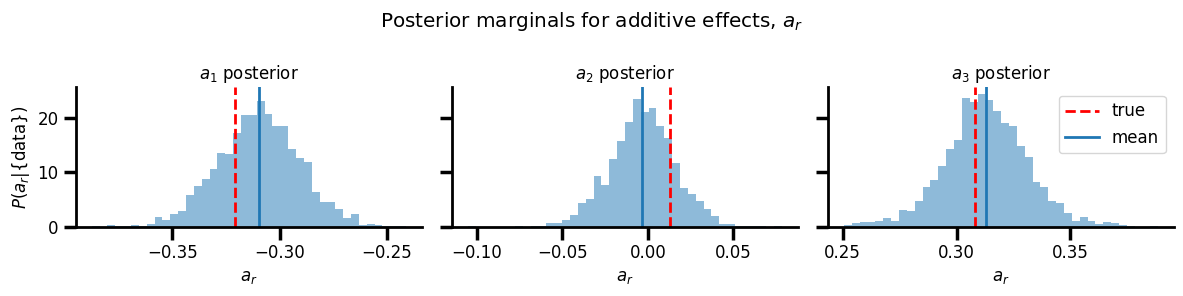

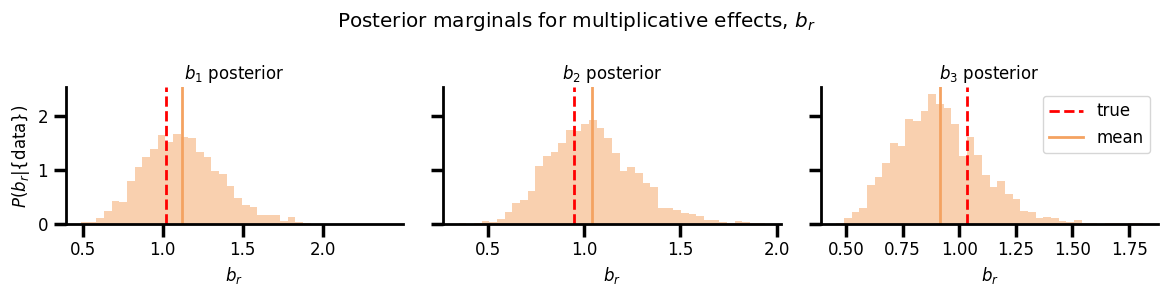

In [5]:
# --- 7) Plot marginal posteriors --- 
# #post["a"] and post["b"] have shape (draws, R)
a_draws = post["a"]        # (draws, R)
b_draws = post["b"]        # (draws, R)

a_hat = a_draws.mean(axis=0)  # posterior means (R,)
b_hat = b_draws.mean(axis=0)

R = a_draws.shape[1]

# --- Plot marginals for a_r ---
fig, axes = plt.subplots(1, R, figsize=(4*R, 3), sharey=True)
if R == 1:
    axes = [axes]
for r in range(R):
    ax = axes[r]
    ax.hist(a_draws[:, r], bins=40, density=True, alpha=0.5)
    ax.axvline(a_true_log[r], linestyle="--", linewidth=2, label="true",color="red",zorder=2)
    ax.axvline(a_hat[r], linestyle="-",  linewidth=2, label="mean")
    ax.set_title(f"$a_{{{r+1}}}$ posterior")
    ax.set_xlabel(r"$a_r$")
axes[0].set_ylabel(r"$P(a_r|\{\text{data}\})$")
axes[-1].legend(loc="best")
fig.suptitle("Posterior marginals for additive effects, $a_r$")
plt.tight_layout()
plt.show()

# --- Plot marginals for b_r ---
fig, axes = plt.subplots(1, R, figsize=(4*R, 3), sharey=True)
if R == 1:
    axes = [axes]
for r in range(R):
    ax = axes[r]
    ax.hist(b_draws[:, r], bins=40, density=True, alpha=0.5,color="#f4a261")
    ax.axvline(b_true[r], linestyle="--", linewidth=2, label="true",color="red",zorder=2)
    ax.axvline(b_hat[r], linestyle="-",  linewidth=2, label="mean",color="#f4a261")
    ax.set_title(f"$b_{{{r+1}}}$ posterior")
    ax.set_xlabel(r"$b_r$")
axes[0].set_ylabel(r"$P(b_r|\{\text{data}\})$")
axes[-1].legend(loc="best")
fig.suptitle("Posterior marginals for multiplicative effects, $b_r$")
plt.tight_layout()
plt.show()

The Bayesian model assumes both effects $a_r,b_r$ are drawn from hyper-distributions, which are assumed to be gaussians with $0$ mean and standard deviations $\tau_a$ and $\tau_b$ respectively. `correct_batch_effect` also returns a sampling of the posterior distribution. Next we illustrate the how to plot the marginal posterior distributions for these parameters as well as recovery performance.

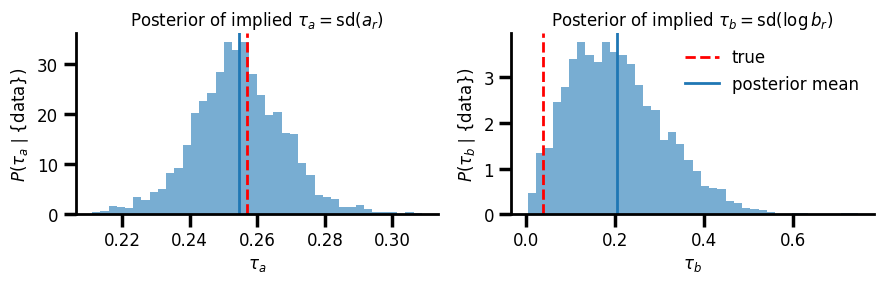

In [6]:
# --- Posterior marginals for implied tau_a and tau_b ------------------------

a_draws = post["a"]        # shape: (draws, R)
b_draws = post["b"]        # shape: (draws, R)

# Compute tau_a and tau_b for each posterior draw
# tau_a = sd(a_r)
# tau_b = sd(log(b_r))

tau_a_draws = np.std(a_draws, axis=1)
tau_b_draws = np.std(np.log(b_draws), axis=1)

tau_a_mean = tau_a_draws.mean()
tau_b_mean = tau_b_draws.mean()

plt.figure(figsize=(9,3))

# --- tau_a ---
plt.subplot(1,2,1)
plt.hist(tau_a_draws, bins=40, density=True, alpha=0.6)
plt.axvline(tau_a_true_eff, ls="--", lw=2, color="red", label="true")
plt.axvline(tau_a_mean, ls="-", lw=2, label="posterior mean")

plt.title(r"Posterior of implied $\tau_a = \mathrm{sd}(a_r)$")
plt.xlabel(r"$\tau_a$")
plt.ylabel(r"$P(\tau_a \mid \{\text{data}\})$")
#plt.legend(frameon=False)

# --- tau_b ---
plt.subplot(1,2,2)
plt.hist(tau_b_draws, bins=40, density=True, alpha=0.6)
plt.axvline(tau_b_true_eff, ls="--", lw=2, color="red", label="true")
plt.axvline(tau_b_mean, ls="-", lw=2, label="posterior mean")

plt.title(r"Posterior of implied $\tau_b = \mathrm{sd}(\log b_r)$")
plt.xlabel(r"$\tau_b$")
plt.ylabel(r"$P(\tau_b \mid \{\text{data}\})$")
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

The posterior for $\sigma_x$

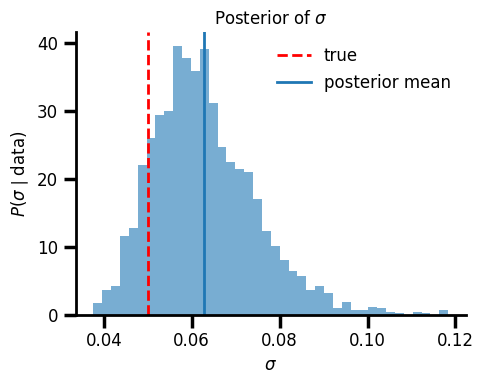

In [7]:

# Extract sigma draws (we stored both log_sigma and sigma in post)
sigma_draws = post["sigma"]   # shape (draws,)
sigma_mean = sigma_draws.mean()

plt.figure(figsize=(5,4))

plt.hist(sigma_draws, bins=40, density=True, alpha=0.6)
plt.axvline(sigma_log_true, ls="--", lw=2, label="true", color="red")
plt.axvline(sigma_mean, ls="-",  lw=2, label="posterior mean")

plt.title(r"Posterior of $\sigma$")
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$P(\sigma \mid \text{data})$")
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

Finally, we illustrate the synthetic dataset before and after batch effect correction

/tmp/ipykernel_528130/4090258699.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot(
/tmp/ipykernel_528130/4090258699.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = plt.boxplot(


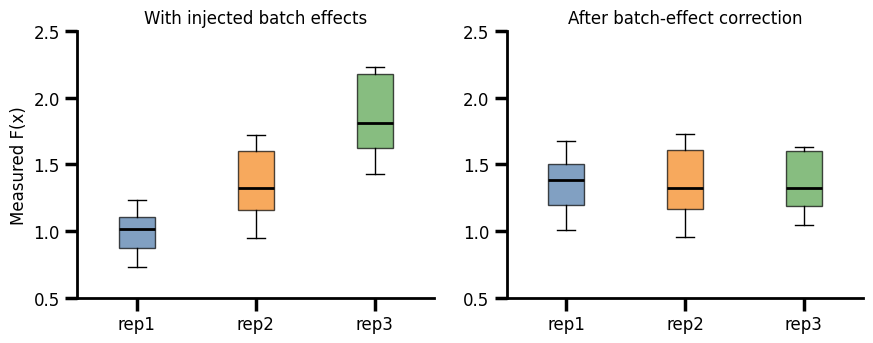

In [8]:
# --- 9) Box plots: injected batch effects vs. after correction (no helper) ---
import matplotlib.pyplot as plt

colors = ["#4C78A8", "#F58518", "#54A24B"]  # one color per replicate

plt.figure(figsize=(9, 3.6))

# Left: with injected batch effects
plt.subplot(1, 2, 1)
vals = L_batchy.values
bp1 = plt.boxplot(
    [vals[:, r] for r in range(L_batchy.R)],
    labels=[f"rep{r+1}" for r in range(L_batchy.R)],
    patch_artist=True
)
# color boxes
for patch, c in zip(bp1["boxes"], colors):
    patch.set(facecolor=c, alpha=0.7)
# style medians
for med in bp1["medians"]:
    med.set(color="black", linewidth=2)
plt.ylabel("Measured F(x)")
plt.title("With injected batch effects")
plt.ylim(0.5,2.5)

# Right: after correction
plt.subplot(1, 2, 2)
vals2 = L_corr.values
bp2 = plt.boxplot(
    [vals2[:, r] for r in range(L_corr.R)],
    labels=[f"rep{r+1}" for r in range(L_corr.R)],
    patch_artist=True
)
for patch, c in zip(bp2["boxes"], colors):
    patch.set(facecolor=c, alpha=0.7)
for med in bp2["medians"]:
    med.set(color="black", linewidth=2)
plt.title("After batch-effect correction")
plt.ylim(0.5,2.5)

plt.tight_layout()
plt.show()

## 4.3. Correction of variance contribution under measurement noise

In practice, the observed landscape $\tilde{F}(\mathbf{x})$ is affected by experimental or observational noise $\xi(\mathbf{x})$. The goal is to estimate how this measurement noise propagates to the Walsh–Hadamard (WH) coefficients $\tilde{f}_{\mathbf{s}}$. 

We first compute the residual covariance $\hat{C}$ across replicate landscapes and project it onto the WH basis $\{\phi_{\mathbf{s}}\}$:

\begin{equation}
\mathrm{Var}[\eta_{\mathbf{s}}]
  = 2^{-2N} \, \phi_{\mathbf{s}}^{\top}\, \hat{C}\, \phi_{\mathbf{s}},
\end{equation}

where $\eta_{\mathbf{s}}$ is the contribution of the measurement noise to mode $\mathbf{s}$. Averaging over all modes of the same order $S = |\mathbf{s}|$ yields the mean projected noise amplitude

\begin{equation}
K_S = \langle \mathrm{Var}[\eta_{\mathbf{s}}] \rangle_{|\mathbf{s}|=S}.
\end{equation}

The total variance observed in each order,

\begin{equation}
V(S) = \sum_{|\mathbf{s}|=S} \tilde{f}_{\mathbf{s}}^2,
\end{equation}

contains both biological signal and noise.
The expected contribution of noise alone is
the **noise floor**

\begin{equation}
V_{\text{noise}}(S) = \binom{N}{S}\, K_S.
\end{equation}

Subtracting this term provides a noise-corrected spectrum,

\begin{equation}
\bar{V}(S) = V(S) - V_{\text{noise}}(S),
\end{equation}

which estimates the true biological variance uncontaminated by replicate noise.


<>:45: SyntaxWarning: invalid escape sequence '\o'
<>:45: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_528130/3156623085.py:45: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(orders_list, V_corr, 'o-', label='Corrected $\overline{V}(k)$', color='#54A24B')


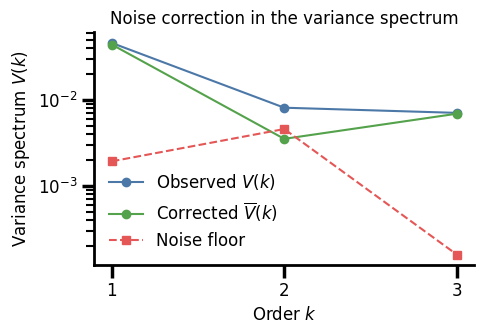

In [9]:

# For example we first increase the noise level across replics
rng = np.random.default_rng(123)
add_sigma = 0.1

V = np.array(L_clean.values, copy=True, dtype=float)
nan_mask = np.isnan(V)
noise = rng.normal(0.0, add_sigma, size=V.shape)
V[~nan_mask] += noise[~nan_mask]

L_noisy = type(L_clean)(L_clean.states, V, L_clean.N, L_clean.R, L_clean.order)

########################################################
#    1) Compute replicate residuals and covariance     #
########################################################
# P : residual matrix (M x R)
# C_hat : covariance of residuals across observed states (M x M)
Xi, C_hat = ep.residuals_and_covariance(L_noisy)

########################################################
#     2) Project noise to the Walsh–Hadamard basis     #
########################################################
# Obtain Var[η_s] for each WH mode and average K_S per order
fs, s_bits, orders, _ = ep.wh_transform(L_noisy.mean_over_replicates(), L_noisy.states, L_noisy.N)
var_eta_s, K_S = ep.project_noise_var_WH(C_hat, L_noisy.states, L_noisy.N, orders)

########################################################
#          3) Correct the variance spectrum            #
########################################################
V_S_obs = ep.variance_spectrum(fs, orders)
V_S_corr = ep.correct_variance_spectrum(V_S_obs, K_S, L_noisy.N)

########################################################
# 4) Visualize observed vs. corrected variance spectra #
########################################################

# Convert dicts to aligned arrays
orders_list = sorted(V_S_obs.keys())
V_obs = np.array([V_S_obs[S] for S in orders_list])
V_corr = np.array([V_S_corr[S] for S in orders_list])
noise_floor = np.array([comb(L_clean.N, S) * K_S.get(S, 0.0) for S in orders_list])

# Plot on log scale for clarity
plt.figure(figsize=(5, 3.5))
plt.plot(orders_list, V_obs, 'o-', label='Observed $V(k)$', color='#4C78A8')
plt.plot(orders_list, V_corr, 'o-', label='Corrected $\overline{V}(k)$', color='#54A24B')
plt.plot(orders_list, noise_floor, 's--', label='Noise floor', color='#E45756')

plt.yscale('log')
plt.xticks(orders_list)
plt.xlabel("Order $k$")
plt.ylabel("Variance spectrum $V(k)$")
plt.title("Noise correction in the variance spectrum")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

